# Proyecto Aprendizaje automático: Heart Failure Prediction.

Grupo 2

Greta Angolani y Héloïse Lafargue

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction


In [152]:
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
import sklearn.preprocessing as sk
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import time

# Estudio del conjunto de datos

## 1) Carga del conjunto de datos y preprocesamiento
---

### a) Presentación del dataset

En este notebook trabajaremos con un conjunto de datos con diferentes características médicas de personas. El objetivo es establecer un diagnóstico sobre si tiene un problema cardiaco o no.

Creamos un dataframe a partir del fichero heart.csv de Kaggle.

In [153]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/AA/proyecto/heart.csv')
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


El conjunto de datos consta de 11 atributos y 2 clases que son "1": heart disease and "0": Normal.
Y hay 918 observaciones para cada atributo.

Las variables son Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak y ST_Slope. Hay variables caterogicas, son las siguientes: 'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'. Las otras son numéricas.

### b) Preprocesamiento : categorización, visualización y normalización

Vamos a convertir las variables catergoricas en variables numéricas mediante el "One hot encoding" con pandas.get_dummies.

In [155]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df_cat = pd.get_dummies(data[categorical_features])
data = data.drop(categorical_features, axis=1)
data = pd.concat([df_cat, data], axis=1)
data.head()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0,1,0,1,0,0,0,1,0,1,...,0,0,1,40,140,289,0,172,0.0,0
1,1,0,0,0,1,0,0,1,0,1,...,0,1,0,49,160,180,0,156,1.0,1
2,0,1,0,1,0,0,0,0,1,1,...,0,0,1,37,130,283,0,98,0.0,0
3,1,0,1,0,0,0,0,1,0,0,...,0,1,0,48,138,214,0,108,1.5,1
4,0,1,0,0,1,0,0,1,0,1,...,0,0,1,54,150,195,0,122,0.0,0


Ahora tenemos 20 atributos y 2 clases posibles ("1": heart disease and "0": Normal).

Después vamos a estudiar la distribucion de los datos para ver si una normalización es necesaria.

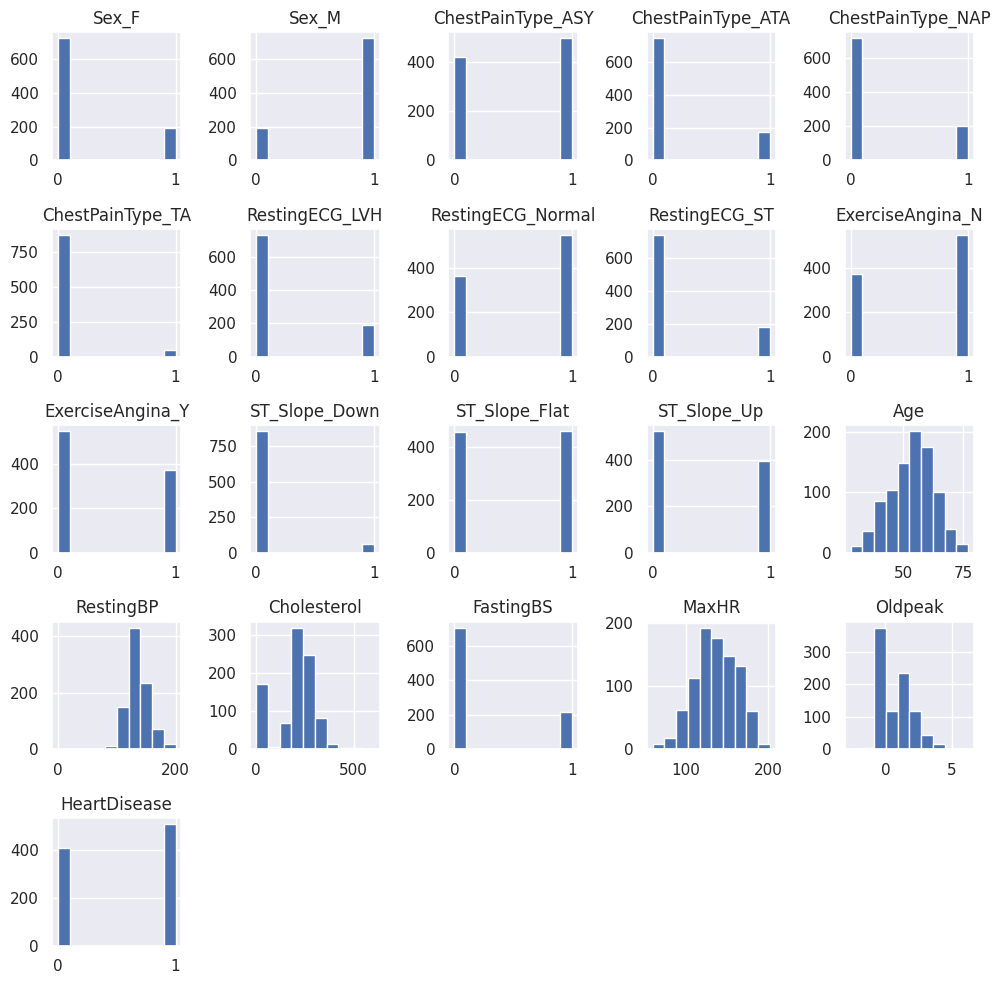

In [156]:
data.hist(figsize=(10, 10))
plt.tight_layout()

La reparticion de los valores de las variables son muy distintas. Hay muchas entre 0 y 1, y otras entre 0 y 500. Tendremos que normalizar.

In [157]:
data.describe()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,...,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.210240,0.789760,0.540305,0.188453,0.221133,0.050109,0.204793,0.601307,0.193900,0.595861,...,0.068627,0.501089,0.430283,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,0.407701,0.407701,0.498645,0.391287,0.415236,0.218289,0.403770,0.489896,0.395567,0.490992,...,0.252957,0.500271,0.495386,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Notamos que hay muchas medias entre 0 y 1 pero tambien unas entre 50 y 140. Asi es pertinente hacer una normalización.

Entonces hacemos la normalización.

In [158]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()
scale_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'] # features that need to be scaled
data[scale_features] = ss.fit_transform(data[scale_features])

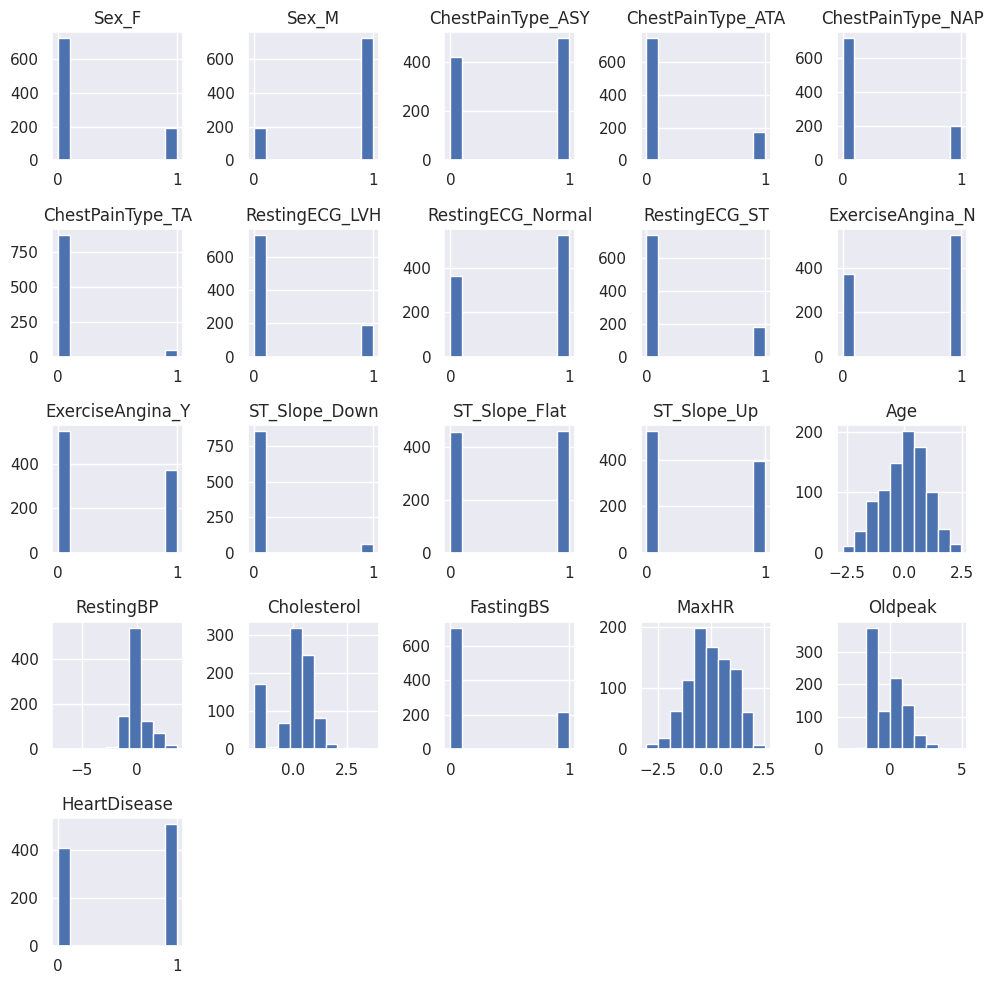

In [159]:
data.hist(figsize=(10, 10))
plt.tight_layout()

Ahora los datos estan entre -2.5 y 2.5, mucho mejor.

Podemos tambien averiguar que no haya valoras duplicadas.

In [160]:
data.duplicated().sum()

0

## 2) Análisis de los datos finales


Compruebamos si las clases a predecir están equilibradas.

Calculamos la correlación de las variables con la variable `HeartDisease` para encontrar las que tienen mayor correlación con la variable de salida.


### a) Frecuencia de las clases

In [161]:
# Número de ejemplos en cada clase
data['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [162]:
# Frecuencia de las clases
data['HeartDisease'].value_counts() / data['HeartDisease'].count() * 100

1    55.337691
0    44.662309
Name: HeartDisease, dtype: float64

<Axes: >

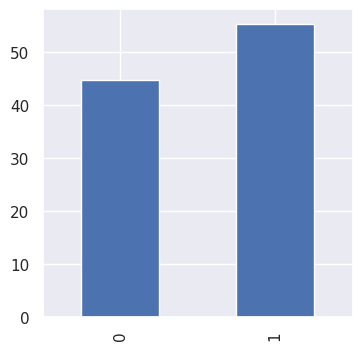

In [163]:
(data['HeartDisease'].value_counts() / data['HeartDisease'].count() * 100).sort_index().plot.bar(figsize=(4, 4))

In [164]:
import plotly.express as px

fig = px.pie(data,names='HeartDisease',title='Frecuencia de Heart Disease',values=np.ones(data.shape[0]),
             color_discrete_sequence=px.colors.sequential.Aggrnyl,hole=1/2)
fig.show()


En nuestro caso la clase «1» (heart disease) es un poco más frecuente “55.3%” que la clase «0» (normal) con una porcentaje de “44.70%”. Pero podemos considerar que las clases están balanceadas y así podemos utilizar el accuracy para medir la eficiencia.

Podemos visualizar el porcentaje de "0" y "1" en el diagrama tambien.

Entonces, el entrenamiento será bastante bueno para cada clase aunque un poquito mejor en la clase "1".


### b) Correlación de las variables



Visualizamos la correlación entre todas las variables y "HeartDisease" con un diagrama de correlacion heatmap.

Text(0.5, 1.0, 'Correlación de las variables con HeartDisease')

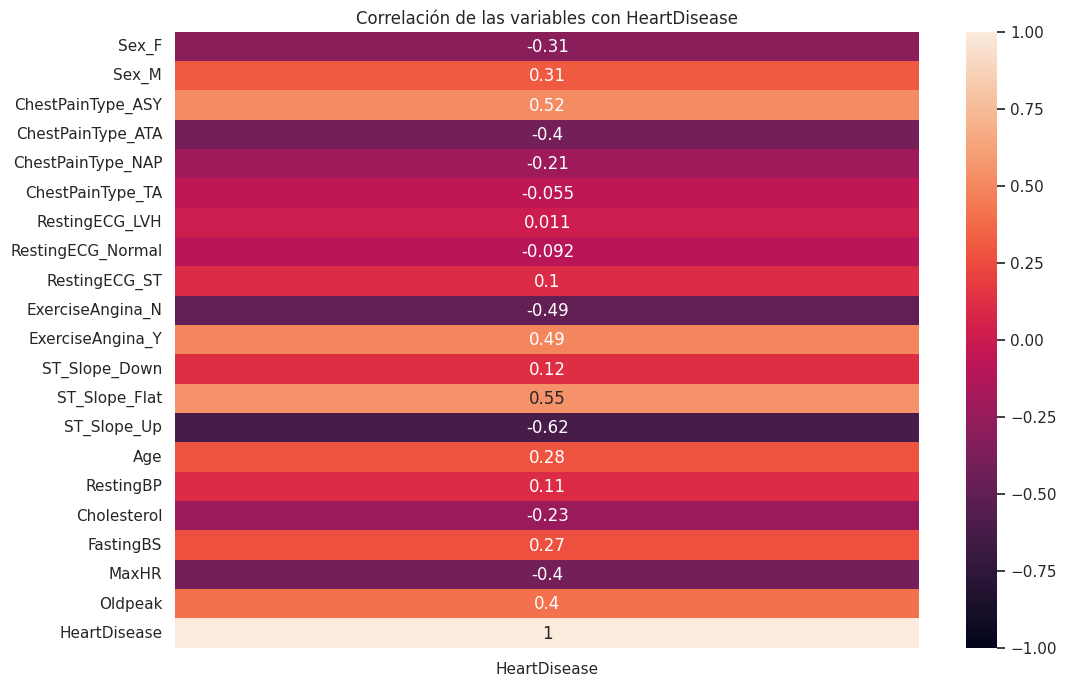

In [165]:
plt.subplots(figsize=(12,8))
sns.heatmap(data.corr()[['HeartDisease']], annot=True, vmin=-1, vmax=1)
plt.title('Correlación de las variables con HeartDisease')

La mayor correlación con la variable de salida es con las 7 variables siguientes: ST_Slope_Flat, ChestPainType_ASY, ExerciseAngina_Y, Oldpeak, Sex_M, Age, FastingBS.

Entonces identificamos estas 7 variables como las mas relevantes para determinar si el paciente tiene un problema cardiaco o no.

### c) Conclusion del análisis de los datos



A tener de todo el análisis, pensamos que el problema es mas bien sencillo de resolver gracias a la relevencia de las 6 variables siguientes: ST_Slope_Flat, ChestPainType_ASY, ExerciseAngina_Y, Oldpeak, Sex_M, Age, FastingBS.

## 3) Separar los datos en entrenamiento, validación y test (60-20-20)

Separamos los datos en entrenamiento, validación y test (60-20-20).

In [166]:
data_array = data.to_numpy()
np.shape(data_array)
X, y = data_array[:, :-1],data_array[:, -1]

print(X.shape)
print(y.shape)


(918, 20)
(918,)


In [167]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

print("Dimension tabla X_train: ", X_train.shape, ", Dimension tabla y_train: ", y_train.shape)
print("Dimension tabla X_val: ", X_val.shape, ", Dimension tabla y_val: ", y_val.shape)
print("Dimension tabla X_test: ", X_test.shape, ", Dimension tabla y_test: ", y_test.shape)

val_size = np.shape(y_val)[0]
test_size = np.shape(y_test)[0]

Dimension tabla X_train:  (550, 20) , Dimension tabla y_train:  (550,)
Dimension tabla X_val:  (184, 20) , Dimension tabla y_val:  (184,)
Dimension tabla X_test:  (184, 20) , Dimension tabla y_test:  (184,)


3. Normalizar los datos

In [168]:
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_val = (X_val - np.mean(X_val, axis=0)) / np.std(X_val, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

Y una vez que hemos comparado la eficiencia de los modelos, vamos a probarlos con todos los datos de entrenamiento es decir los de entrenaliento y validacion.

In [169]:
x = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

# Regresión logística regularizada

## a) Adaptación

Lo unico que cambiamos es la eleccion de los datos de entrenamiento y de validacion para el entrenamiento y los datos de test para la prediccion.

##b) Ajuste

### b.1°) Definición de las funciones 

#### Función sigmoide

In [170]:
def sigmoide(z):
    """
    return the sigmoid of z
    """
    return 1 / (1 + np.exp(-z))

#### Cálculo de la función de regularizada coste y su gradiente

In [171]:
def cost(x,y,w,b,lamb):
    """
    Compute the cost function and the gradients (of the weight vector and bias term) 
    of a logistic regression model with regularization.
    The inputs are the feature matrix X, target vector y, weight vector w,
    bias term b, and regularization parameter lambda.
    """
    m = len(y)
    f_wb = sigmoide(np.dot(x,w)+b)
    term1 = np.dot(-y, np.log(f_wb))
    term2 = np.dot((1 - y), np.log(1 - f_wb))
    term_regu = (lamb / (2 * m)) * np.sum(np.square(w))
    J = (np.sum(term1 - term2)  / m) + term_regu

    gradW = (1/m) * np.dot((f_wb - y),x) + (lamb/m)*w
    gradB = (1/m) * np.sum((f_wb - y))
    return J, gradW, gradB

#### Método de descenso de gradiente

In [172]:
def gradient_descent(XX,Y, alpha, max_iter, lamb):
    
    npoly = XX.shape[1]
    w, tmp_w = np.zeros(npoly), np.zeros(npoly)
    b = 0
    J_history = []
    
    for iter in range(max_iter):
        J, dJ_w, dJ_b = cost(XX,Y,w,b,lamb)
        tmp_w = w - (alpha * dJ_w)
        tmp_b = b - (alpha * dJ_b)
        w, b = tmp_w, tmp_b
        J_history.append(cost(XX, Y, w, b, lamb)[0]) 
    return w, b, J_history


#### Accuracy

In [173]:
def accuracy(X, y, w, b, cutoff):
    pred = [sigmoide(np.dot(X, w) + b) >= cutoff]
    acc = np.mean(pred == y)
    return (acc * 100)
    

### b.2°) Cálculo del valor óptimo de los parámetros y efectos de la regularización

In [174]:
# Evaluate the optimal for different λ

cases = {"0": 0, "1": 1, "10": 10, "50": 50, "80": 80, "100": 100}

porc =[]

for k, lamb in cases.items():
    
    # Gradient Descent Method
    learning_rate, max_iter = 0.001, 100000
    w_min, b_min, J = gradient_descent(x,y, learning_rate, max_iter, lamb)
    
    # Accuracy of the logistic regularized regression
    porcentage = accuracy(X_test, y_test, w_min, b_min, 0.5)
    porc.append(porcentage)
    print(100 * "-")
    print('\n The accuracy of the classifier for λ = ', lamb, ' is of ', "%.2f" % porcentage, '%.')


----------------------------------------------------------------------------------------------------

 The accuracy of the classifier for λ =  0  is of  84.78 %.
----------------------------------------------------------------------------------------------------

 The accuracy of the classifier for λ =  1  is of  84.78 %.
----------------------------------------------------------------------------------------------------

 The accuracy of the classifier for λ =  10  is of  84.24 %.
----------------------------------------------------------------------------------------------------

 The accuracy of the classifier for λ =  50  is of  83.70 %.
----------------------------------------------------------------------------------------------------

 The accuracy of the classifier for λ =  80  is of  84.24 %.
----------------------------------------------------------------------------------------------------

 The accuracy of the classifier for λ =  100  is of  84.24 %.


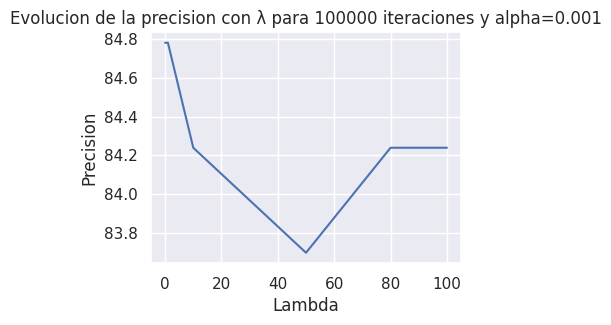

In [175]:
plt.figure(figsize=(4,3))
plt.plot([0,1,10,50,80,100],porc)
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Evolucion de la precision con λ para 100000 iteraciones y alpha=0.001')
plt.show()

Cuando λ es grande (10,50,80,100) hay un riesgo de underfitting (precision mas baja). Para λ=1 el fitting es bueno.

## c) Resultados

In [176]:
start_time = time.time()

# Gradient Descent Method
learning_rate, max_iter = 0.001, 100000
w_min, b_min, J = gradient_descent(x,y, learning_rate, max_iter, 1)

# Prediction and Accuracy of the logistic regularized regression
pred = [sigmoide(np.dot(X_test, w_min) + b_min) >= 0.5]
acc_regLog = np.mean(pred == y_test) * 100

end_time = time.time()
execution_time_reglog = end_time - start_time
print("El tiempo de ejecución  es", execution_time_reglog, "segundos")

El tiempo de ejecución  es 40.98577046394348 segundos


In [177]:
y_pred_reglog = [int(elem) for elem in pred[0]]

In [178]:
cm_reglog = confusion_matrix(y_test,y_pred_reglog)
print("La matriz de confusion es \n", cm_reglog)

La matriz de confusion es 
 [[66 16]
 [12 90]]


In [179]:
print("Con la regresion logistica, la accuracy es", acc_regLog)

Con la regresion logistica, la accuracy es 84.78260869565217


# Red neuronal con TensorFlow

Implementamos varias redes neuronales en tensorflow para determinar cual es la mejor configuración.

Hay que probar 3 configuraciones (de 3 capas):
- un modelo complejo con muchas neuronas, 
- un modelo simple con pocas neuronas,
- un modelo complejo con muchas neuronas y regularización, ajustando el mejor valor de lambda (utilizamos una visualización).

Pintamos las curvas de aprendizaje de las 3 configuraciones y explicamos lo que se muestra.

Elegimos los mejores valores de los hiperparámetros.


In [180]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## a) Adaptación

Lo unico que cambiamos es la eleccion de los datos de entrenamiento y de validacion para el entrenamiento y los datos de test para la prediccion.

## b) Ajuste

### Modelo complejo con muchas neuronas
Usamos 100 neuronas en la primera capa y muchas epochs

In [181]:
classes = 2

1. Entrenamiento con distintos tamanos de entrenamiento y curva de aprendizaje

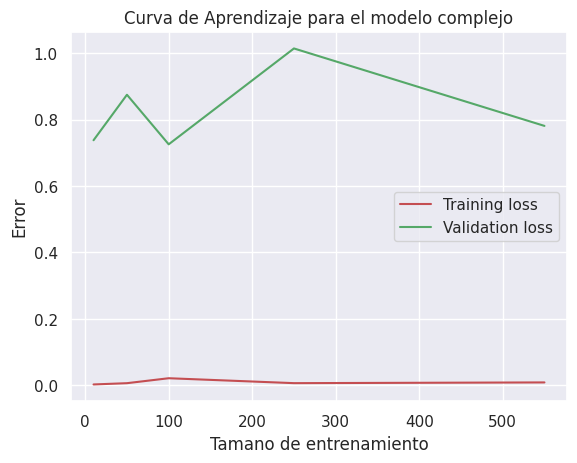

In [182]:
import matplotlib.pyplot as plt

train_size = [10, 50, 100, 250, 550]
train_loss = []
val_loss = []

for k in (train_size) :
  model_1 = Sequential([
      Dense(100, activation='relu'),
      Dense(60, activation='relu'),
      Dense(2, activation='linear')
  ])
  model_1.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model_1.fit(X_train[:k, :], y_train[:k], epochs=100, batch_size=32, verbose=0)

  train_loss_k, _ = model_1.evaluate(X_train[:k, :], y_train[:k], verbose=0)
  val_loss_k, _ = model_1.evaluate(X_val, y_val, verbose=0)

  train_loss.append(train_loss_k)
  val_loss.append(val_loss_k)

# Plot the learning curve
plt.plot(train_size, train_loss, color='r', label='Training loss')
plt.plot(train_size, val_loss, color='g', label='Validation loss')
plt.xlabel('Tamano de entrenamiento')
plt.ylabel('Error')
plt.title('Curva de Aprendizaje para el modelo complejo')
plt.legend(loc='best')
plt.show()


Con la curva de aprendizaje, vemos que el "bias" es bajo y la "variance"  alta, esto significa que estamos en un caso de Overfitting.

El overfitting se produce cuando el modelo funciona bien en el conjunto de entrenamiento, pero mucho peor en el conjunto de validación (variance alta). Otra observación importante que podemos hacer aquí es que es muy probable que la adición de nuevas instancias de entrenamiento conduzca a modelos mejores.

2. Curva de la precisión con todos los datos de entrenamiento

Pintamos la precisión en el conjunto de entrenamiento y validación en función del número de épocas. Si el modelo está sobreajustando, la precisión en el conjunto de entrenamiento será mayor que la precisión en el conjunto de validación, y esto se puede ver claramente en la gráfica.

In [183]:
# Neural network
model_1 = Sequential([
    Dense(100, activation='relu'),
    Dense(60, activation='relu'),
    Dense(classes, activation='linear')
])

model_1.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history_1 = model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=0)

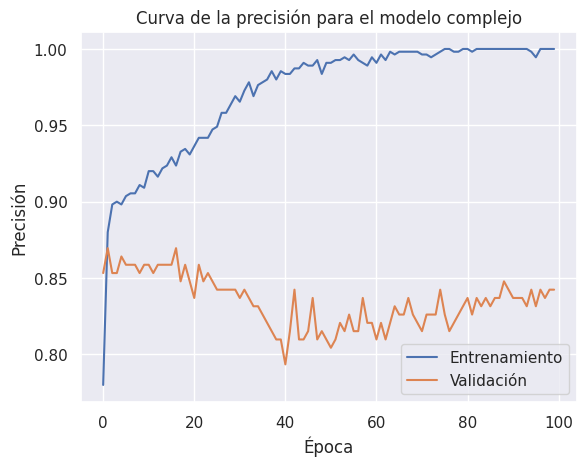

In [184]:
# Grafica de la precisión en el conjunto de entrenamiento y validación
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Curva de la precisión para el modelo complejo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()


Aqui vemos en la gráfica que el modelo está sobreajustando: la precisión en el conjunto de entrenamiento sobrepasa la precisión del conjunto de validación.

Es un caso de "overfitting" cuando se toma demasiado épocas. Para evitar overfitting tendriamos que hacer el fitting con menos de 5 épocas.

3. Entrenamiento con los datos de entrenamiento y validacion, y Predicción

In [185]:
# Neural network
model_1 = Sequential([
    Dense(100, activation='relu'),
    Dense(60, activation='relu'),
    Dense(classes, activation='linear')
])

model_1.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history_1 = model_1.fit(x, y, epochs=100, batch_size=32, verbose=0) # con todos los datos de entrenamiento

In [186]:
newY = np.zeros((test_size, 1), dtype='int64')

for i in range (test_size):
  pi = model_1.predict(X_test[i].reshape(1,20), verbose = 0)   #change 2 columns -> 20
  prediction_p = tf.nn.softmax(pi).numpy()
  yhat = np.argmax(prediction_p)

  newY[i] = yhat

In [187]:
cm = confusion_matrix(y_test,newY)
print("La matriz de confusion es \n", cm)

La matriz de confusion es 
 [[66 16]
 [15 87]]


In [188]:
#Accuracy
from sklearn.metrics import accuracy_score
print("Training Set Accuracy:", accuracy_score(newY, y_test)*100,"%")

Training Set Accuracy: 83.15217391304348 %


El modelo complejo funciona bastante bien (82% de precisión) pero hemos visto que somos en un caso de "overfitting".

### Modelo simple con pocas neuronas
Usamos 10 neuronas en la primera capa y pocas epochs

1. Entrenamiento con distintos tamanos de entrenamiento y curva de aprendizaje

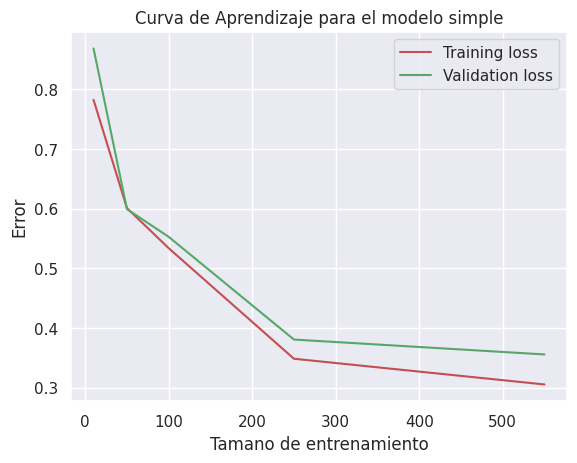

In [258]:
train_size = [10, 50, 100, 250, 550]
train_loss = []
val_loss = []

for k in (train_size) :
  model_2 = Sequential([
      Dense(10, activation='relu'),
      Dense(6, activation='relu'),
      Dense(classes, activation='linear')
  ])
  model_2.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model_2.fit(X_train[:k, :], y_train[:k], epochs=20, batch_size=32, verbose=0)

  train_loss_k, _ = model_2.evaluate(X_train[:k, :], y_train[:k], verbose=0)
  val_loss_k, _ = model_2.evaluate(X_val, y_val, verbose=0)

  train_loss.append(train_loss_k)
  val_loss.append(val_loss_k)

# Plot the learning curve
plt.plot(train_size, train_loss, color='r', label='Training loss')
plt.plot(train_size, val_loss, color='g', label='Validation loss')
plt.xlabel('Tamano de entrenamiento')
plt.ylabel('Error')
plt.title('Curva de Aprendizaje para el modelo simple')
plt.legend(loc='best')
plt.show()


Con esta curva de aprendizaje, vemos que el "bias" es bastante baja y la "variance" baja. Esto significa que es el modelo funciona bastante bien.

2. Curva de la precisión con todos los datos de entrenamiento

In [246]:
# Neural network
model_2 = Sequential([
    Dense(10, activation='relu'),
    Dense(6, activation='relu'),
    Dense(classes, activation='linear')
])

model_2.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)


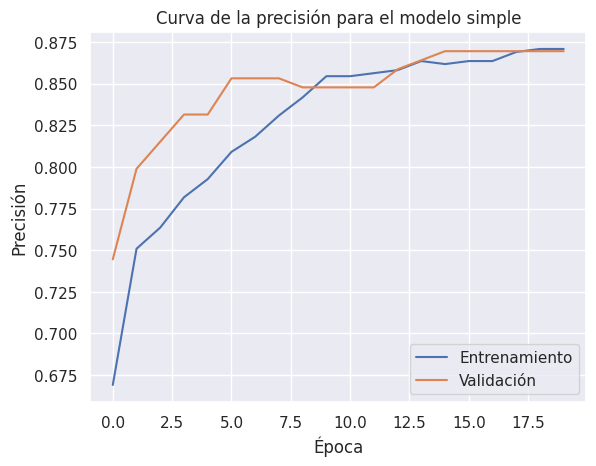

In [247]:
# Grafica de la precisión en el conjunto de entrenamiento y validación
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Curva de la precisión para el modelo simple')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

Aqui vemos en la gráfica que el modelo no sobreajusta ni subajusta: la precisión en el conjunto de entrenamiento esta muy cerca de la precisión del conjunto de validación.

3. Predicción

In [248]:
# Neural network
model_2 = Sequential([
    Dense(10, activation='relu'),
    Dense(6, activation='relu'),
    Dense(classes, activation='linear')
])

model_2.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history_2 = model_2.fit(x, y, epochs=20, batch_size=32, verbose=0)  # con todos los datos de entrenamiento


In [249]:
newY_2 = np.zeros((test_size, 1), dtype='int64')

for i in range (test_size):
  pi = model_2.predict(X_test[i].reshape(1,20), verbose = 0)    #change 2 columns -> 20
  prediction_p = tf.nn.softmax(pi).numpy()
  yhat = np.argmax(prediction_p)

  newY_2[i] = yhat

In [250]:
cm = confusion_matrix(y_test,newY_2)
print("La matriz de confusion es \n", cm)

La matriz de confusion es 
 [[64 18]
 [14 88]]


In [251]:
#Accuracy
print("Training Set Accuracy:", accuracy_score(newY_2, y_test)*100,"%")

Training Set Accuracy: 82.6086956521739 %


El modelo simple funciona muy bien con 85% de precisión.



### Modelo complejo con muchas neuronas y regularización

1. Ajuste del mejor valor de lambda con visualización

Para encontrar los mejores hiperparámetros para el modelo complejo con muchas neuronas y regularización, se puede variar el valor de lambda en el rango [0.001, 0.01, 0.1, 1.0, 10.0] y seleccionar el valor que da la mejor precisión.

In [259]:
# Definir rango de valores para lambda
lambda_range = [0.001, 0.01, 0.1, 1.0, 10.0]

for lamb in lambda_range:    
    # Neural network    
    model_3 = Sequential([
      Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
      Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
      Dense(classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamb))
    ])
    model_3.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    model_3.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    train_loss, _ = model_3.evaluate(X_train, y_train, verbose=0)
    val_loss, _ = model_3.evaluate(X_val, y_val, verbose=0)

    print("Para el modelo con λ = ", lamb, ", train_loss = ", train_loss, " y val_loss = ", val_loss)

Para el modelo con λ =  0.001 , train_loss =  0.10727614909410477  y val_loss =  0.6750984787940979
Para el modelo con λ =  0.01 , train_loss =  0.30881088972091675  y val_loss =  0.40904954075813293
Para el modelo con λ =  0.1 , train_loss =  0.567575991153717  y val_loss =  0.5489784479141235
Para el modelo con λ =  1.0 , train_loss =  0.6875812411308289  y val_loss =  0.6872302889823914
Para el modelo con λ =  10.0 , train_loss =  0.6875782608985901  y val_loss =  0.6872363686561584


Asi, el mejor resultado se obtiene con un bias bajo (eliminamos los λ> 0.01 que tienen un error>0.5) y una variance baja (0.521 con λ = 0.001 -> riesgo de sobreajuste; 0.03 con λ = 0.01 -> bien) asi que elegimos a λ =  0.01.

Podemos pintar la curva de aprendizaje con el lambda optimo. 




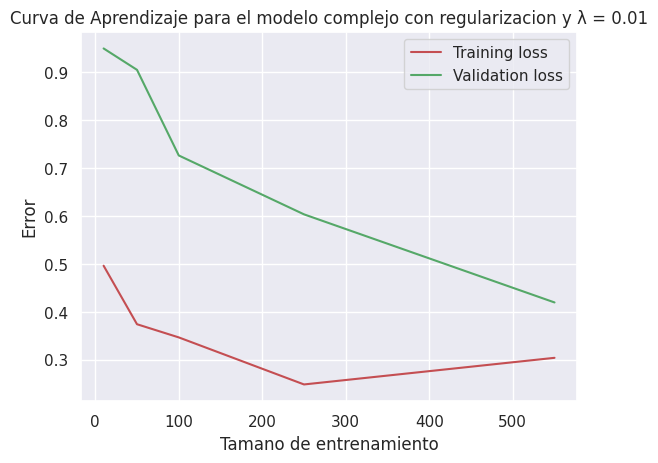

In [260]:
train_size = [10, 50, 100, 250, 550]
train_loss = []
val_loss = []
lamb = 0.01

for k in (train_size) :
  model_3 = Sequential([
      Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
      Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
      Dense(classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamb))
    ])
  model_3.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
  model_3.fit(X_train[:k, :], y_train[:k], epochs=100, batch_size=32, verbose=0)

  train_loss_k, _ = model_3.evaluate(X_train[:k, :], y_train[:k], verbose=0)
  val_loss_k, _ = model_3.evaluate(X_val, y_val, verbose=0)

  train_loss.append(train_loss_k)
  val_loss.append(val_loss_k)

# Plot the learning curve
plt.plot(train_size, train_loss, color='r', label='Training loss')
plt.plot(train_size, val_loss, color='g', label='Validation loss')
plt.xlabel('Tamano de entrenamiento')
plt.ylabel('Error')
plt.title('Curva de Aprendizaje para el modelo complejo con regularizacion y λ = 0.01')
plt.legend(loc='best')
plt.show()


Con la curva de aprendizaje, vemos que el "bias" es bajo y la "variance" bastante alta, esto significa que el modelo sobreajusta un poco.

El modelo funciona mejor que sin la regularizacion en el conjunto de entrenamiento y en el conjunto de validación. La regularizacion a permitido bajar un poco la variance.


2. Entrenamiento con λ = 0.1

In [261]:
lamb = 0.01
model_3 = Sequential([
    Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
    Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
    Dense(classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamb))
])

model_3.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

history_3 = model_3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=0)


3. Curva de la precisión con todos los datos de entrenamiento con λ = 0.1

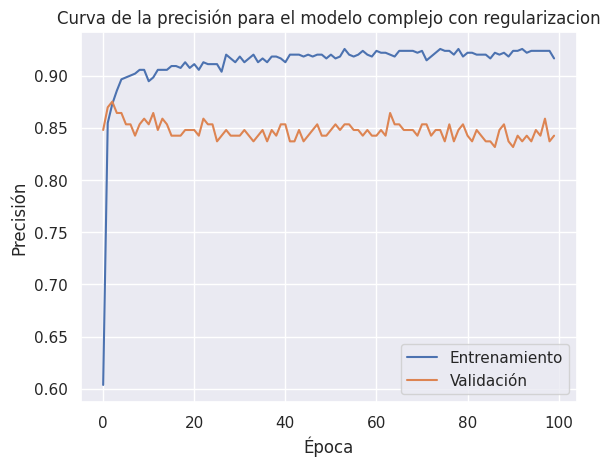

In [262]:
# Grafica de la precisión en el conjunto de entrenamiento y validación
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Curva de la precisión para el modelo complejo con regularizacion')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

Aqui vemos en la gráfica que el modelo esta sobreaprendiendo. La precisión en el conjunto de entrenamiento sobrepasa la precisión del conjunto de validación.

Es un caso de "overfitting".


4. Predicción con λ = 0.1

In [263]:
lamb = 0.01
model_3 = Sequential([
    Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
    Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
    Dense(classes, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(lamb))
])

model_3.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

history_3 = model_3.fit(x, y, epochs=100, batch_size=32, verbose=0) # con todos los datos de entrenamiento

In [264]:
newY_3 = np.zeros((test_size, 1), dtype='int64')

for i in range (test_size):
  pi = model_3.predict(X_test[i].reshape(1,20), verbose = 0)    #change 2 columns -> 20
  prediction_p = tf.nn.softmax(pi).numpy()
  yhat = np.argmax(prediction_p)

  newY_3[i] = yhat

In [265]:
cm = confusion_matrix(y_test,newY_3)
print("La matriz de confusion es \n", cm)

La matriz de confusion es 
 [[67 15]
 [12 90]]


In [266]:
#Accuracy
print("Training Set Accuracy:", accuracy_score(newY_3, y_test)*100,"%")

Training Set Accuracy: 85.32608695652173 %


### Conclusión sobre los hiperparámetros

Para elegir los valores de los hiperparámetros en este caso, consideramos lo siguiente:

- Número de neurona en las capas escondidas de la red: cuanto mas neuronas hay en la primera capa, mejor puede ser capaz de aprender representaciones más complejas, pero puede ser propensa a sobreajustar (overfitting) los datos de entrenamiento. Para evitar el sobreajuste, se puede usar la regularización, como la penalización L2. Si el número de neuronas en la primera capa no es suficiente puede que haya un subajuste (underfitting). 

- Número de épocas: El número de épocas determina cuántas veces se recorren los datos de entrenamiento durante el entrenamiento. Si el número de épocas es demasiado bajo, la red puede no tener tiempo suficiente para converger. Si el número de épocas es demasiado alto, la red puede sobreajustarse a los datos de entrenamiento.

- Valor óptimo de lambda para la regularización: El valor de lambda en la regularización L2 controla la magnitud de los coeficientes de los pesos en la función de coste del modelo. Cuando lambda es muy pequeño, los pesos pueden tomar valores grandes y llevar a un sobreajuste del modelo. Cuando lambda es muy grande, los pesos se acercan a cero y pueden llevar a un subajuste del modelo. Por lo tanto, se debe elegir un valor de lambda cuidadosamente para encontrar un equilibrio entre la complejidad del modelo y su capacidad de generalización.

Para concluir: para nuestro conjunto de datos funciona mejor el modelo con pocas neuronas en la primera capa de la red.

## c) Resultados

Usamos el mejor modelo:

In [270]:
start_time = time.time()

# Neural network
model_2 = Sequential([
    Dense(10, activation='relu'),
    Dense(6, activation='relu'),
    Dense(classes, activation='linear')
])

model_2.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history_2 = model_2.fit(x, y, epochs=20, batch_size=32, verbose=0)  # con todos los datos de entrenamiento

newY_2 = np.zeros((test_size, 1), dtype='int64')

for i in range (test_size):
  pi = model_2.predict(X_test[i].reshape(1,20), verbose = 0)    #change 2 columns -> 20
  prediction_p = tf.nn.softmax(pi).numpy()
  yhat = np.argmax(prediction_p)

  newY_2[i] = yhat

end_time = time.time()

# Calcul du temps d'exécution
execution_time_red = end_time - start_time

# Affichage du temps d'exécution
print("Con las redes neuronales, el tiempo de ejecución es :", execution_time_red, "segundos.")

Con las redes neuronales, el tiempo de ejecución es : 14.21835207939148 segundos.


In [271]:
cm_red = confusion_matrix(y_test,newY_2)
print("La matriz de confusion es \n", cm_red)

La matriz de confusion es 
 [[64 18]
 [10 92]]


In [272]:
#Accuracy
acc_red = accuracy_score(newY_2, y_test)*100
print("Training Set Accuracy:", acc_red ,"%")

Training Set Accuracy: 84.78260869565217 %


Para nuestro conjunto de datos, el modelo de red neuronal simple con pocas neuronas en la primera capa funciona mejor que un modelo complejo con regularización por varias razones:

- Sobreajuste: un modelo complejo con un gran número de neuronas y técnicas de regularización puede tener más probabilidades de sobreaprender. Cuando un modelo es demasiado complejo, puede aprender a memorizar ejemplos de entrenamiento en lugar de generalizar a nuevos ejemplos. Esto puede dar lugar a un rendimiento deficiente a la hora de predecir datos desconocidos. Por el contrario, un modelo sencillo con menos neuronas tiene menos probabilidades de sobreaprender y puede generalizar con más eficacia.

- Dilema bias-varianza: El dilema bias-varianza es un concepto importante en el aprendizaje automático. Un modelo con un bias alto (subaprendizaje) puede no ser lo bastante complejo para captar patrones complejos en los datos, mientras que un modelo con una varianza alta (sobreaprendizaje) puede ser demasiado complejo y demasiado sensible a pequeñas variaciones en los datos de entrenamiento. Al elegir un modelo simple con pocas neuronas, se reduce el riesgo de sobreaprendizaje y se puede encontrar un buen compromiso entre bias y varianza.

- Interpretabilidad: los modelos sencillos suelen ser más fáciles de interpretar que los complejos. Con menos neuronas, es más fácil entender las relaciones entre las entradas y salidas de la red neuronal. Esto puede ser útil en ámbitos en los que la interpretabilidad es una prioridad, como la medicina o las finanzas.

- Coste computacional: los modelos complejos con un gran número de neuronas pueden requerir más recursos computacionales y de memoria para el entrenamiento y la inferencia. Si se utiliza un modelo sencillo, se pueden reducir las necesidades de recursos, lo que puede ser beneficioso en términos de tiempo de ejecución y coste.

Sin embargo, es importante tener en cuenta que el rendimiento de un modelo depende de la complejidad del problema y de la disponibilidad de datos de entrenamiento. En algunos casos, puede ser necesario un modelo complejo con regularización para lograr un mejor rendimiento. Por lo tanto, es esencial experimentar y evaluar diferentes arquitecturas de modelos para encontrar la mejor solución para cada problema específico.


# Árboles con XGBoost





## a) Adaptación

Lo unico que cambiamos es la eleccion de los datos de entrenamiento y de validacion para el entrenamiento y los datos de test para la prediccion.

## b) Ajuste

Modelo de múltiples árboles con XGBoost

Vamos a ver la influencia de los parametros siguientes del Tree Booster : 'eta' (learning rate) y 'lambda' (L2 regularization term on weights) y por eso observamos la evolucion de la accuracy. (https://xgboost.readthedocs.io/en/stable/parameter.html) 

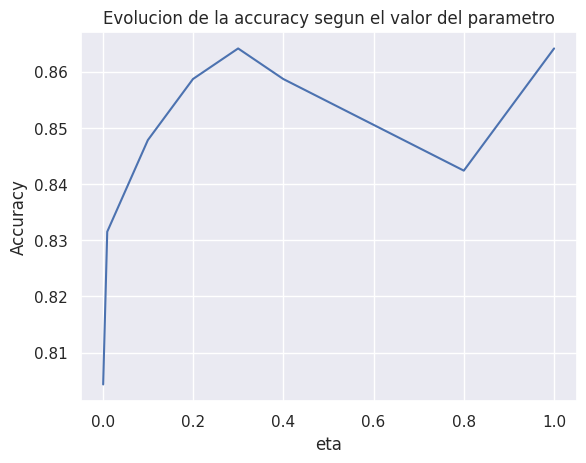

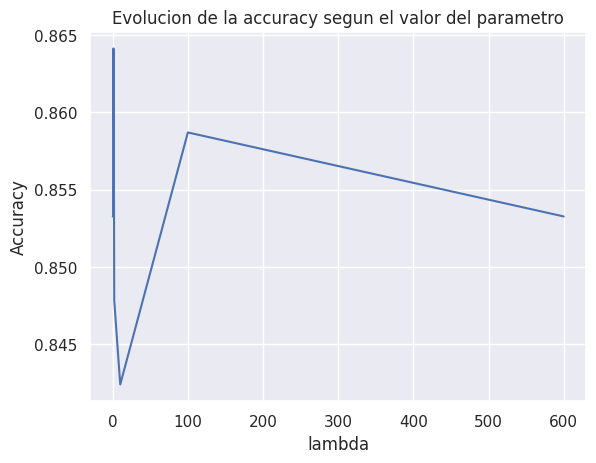

In [273]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(params):
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def plot_param_influence(param_name, param_range):
    scores = []
    for param_value in param_range:
      params = {
          param_name: param_value
      }
      score = train_model(params)
      scores.append(score)
    plt.plot(param_range, scores)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title("Evolucion de la accuracy segun el valor del parametro")
    plt.show()

eta_range = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.8, 1]
lambda_range = [0.1, 0.5, 1, 1.5, 2, 10, 100, 600]

plot_param_influence('eta', eta_range)
plot_param_influence('lambda', lambda_range)


Con los gráficos de la accuracy, vemos que los parámetros influyen en la eficiencia del modelo y podemos ver que la mejor accuracy se obtiene con un “learning rate” (eta) de 0.3 y un λ de 1.

## c) Resultados

Ahora entrenamos el modelo con los parametros optimos y visualizamos la el resultado de la prediccion con la matriz de confusion y el arbol XGBoost asociado al modelo.

La matriz de confusion es 
 [[67 15]
 [10 92]]
La accuracy es  86.41304347826086
Con XGBoost, el tiempo de ejecucion es : 0.10966706275939941 segundos
El arbol XGBoost es


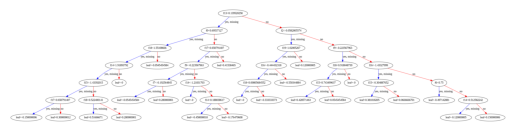

In [274]:
from xgboost import XGBClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

start_time = time.time()

params = {
    'eta': 0.3, # learning rate
    'lambda': 1 # L2 regularization term on weights
}

# fitting con todos los datos de entrenamiento y de validacion
model = XGBClassifier(**params)
model.fit(X_train, y_train)

# prediction
y_pred_xgb = model.predict(X_test)
cm_xgb = confusion_matrix(y_test,y_pred_xgb)
print("La matriz de confusion es \n", cm_xgb)
acc_xgb = accuracy_score(y_test, y_pred_xgb) * 100
print("La accuracy es ", acc_xgb)

end_time = time.time()
execution_time_xgb = end_time - start_time
print("Con XGBoost, el tiempo de ejecucion es :", execution_time_xgb, "segundos")

# plot tree
print("El arbol XGBoost es")
plot_tree(model); 

# Comparacion

In [275]:
print("_________ Regresión logística regularizada ")
print("La matriz de confusion es \n", cm_reglog)
print("La accuracy es ", acc_regLog)
print("El tiempo de ejecución es :", execution_time_reglog, "segundos \n")

print("_________ Red neuronal ")
print("La matriz de confusion es \n", cm_red)
print("La accuracy es ", acc_red)
print("El tiempo de ejecución es :", execution_time_red, "segundos \n")

print("_________ Arboles XBGoost ")
print("La matriz de confusion es \n", cm_xgb)
print("La accuracy es ", acc_xgb)
print("El tiempo de ejecución es :", execution_time_xgb, "segundos")

_________ Regresión logística regularizada 
La matriz de confusion es 
 [[66 16]
 [12 90]]
La accuracy es  84.78260869565217
El tiempo de ejecución es : 40.98577046394348 segundos 

_________ Red neuronal 
La matriz de confusion es 
 [[64 18]
 [10 92]]
La accuracy es  84.78260869565217
El tiempo de ejecución es : 14.21835207939148 segundos 

_________ Arboles XBGoost 
La matriz de confusion es 
 [[67 15]
 [10 92]]
La accuracy es  86.41304347826086
El tiempo de ejecución es : 0.10966706275939941 segundos


Analisis de los resultados:

Analizando los resultados proporcionados para los tres modelos, podemos hacer las siguientes comparaciones:

- Precisión (Accuracy):

  Regresión logística regularizada: 84.78%

  Red neuronal: 84.78%

  Árboles XGBoost: 86.41%

Basado en la precisión, el modelo de árboles XGBoost muestra el rendimiento más alto, con una precisión del 86.41%. Sin embargo, la diferencia de precisión entre los tres modelos no es muy significativa.

- Tiempo de ejecución:

  Regresión logística regularizada: 41.00 segundos

  Red neuronal: 14.22 segundos

  Árboles XGBoost: 0.11 segundos

En términos de eficiencia temporal, el modelo de árboles XGBoost es el más rápido, con un tiempo de ejecución de solo 0.11 segundos. La regresión logística regularizada es el más lento, con un tiempo de ejecución de 41.00 segundos.

- Matriz de confusión:

Tenemos bastante buenos resultados con la red neuronal y el XGBoost, sin embargo XGBoost funciona mejor. Y mas importante, da menos Falsos Negativos y Falses Verdaderos lo que es muy importante para la prediccion de enfermedades cardiovasculares.

Asi concluimos que XGBoost es el mejor modelo para predecir enfermedades cardiovasculares.


# Conclusiones

El mejor modelo para nuestro conjunto de datos es XGBoost tree. Obtenemos la mejor accuracy y el mejor tiempo de ejecución  y tambien, menos Falsos negativos.

Dado que XGBoost funciona en un proceso iterativo que combina árboles débiles y en cada iteración se agrega un nuevo árbol al conjunto para compensar los errores cometidos por los modelos anteriores, podemos inferir que obtuvo los mejores resultados en términos de precisión y "falsos negativos" por esta razón.

XGBoost es rápido y eficaz, y con la regularización incorporada permite evitar el sobreajuste. Al final es un algoritmo muy competitivo para el aprendizaje automático.
